In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
img_path = '/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/'
csv_path = '/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/train.csv'

In [3]:
df_defect = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/labels.csv', sep=" ")
df_train = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/train.csv', sep=" ")
df_test = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv', sep=" ")

In [4]:
window_size = 85
pad_size= window_size

In [5]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    mask = mask.astype(int)
    return mask
mask = create_circular_mask(200,200)

In [6]:
class defectDataset_csv(Dataset):
    def __init__(self, csv_path='/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/train.csv', img_path='/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/', window_size=50, pad_size=50, mask = mask, transforms=None):
        """
        Args:
            csv_path (string): path to csv file
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = pd.read_csv(csv_path, sep=" ")
        self.img_path = img_path
        self.transforms = transforms
        self.window_size = window_size
        self.pad_size = pad_size
        self.mask = mask

    def __getitem__(self, index):
        labels = self.data.loc[index]
        single_image_label = int(labels['class']) # float
        x = labels['x']
        y = 1 - labels['y'] # origin of PIL image is top-left
        img_index = labels['image_index']
        img = Image.open(self.img_path + '%06.0f.jpg' % img_index)
        img = img.convert('L')
        img = torchvision.transforms.functional.resize(img, (300,300), interpolation=2)
        width, height = img.size
        img = ImageOps.expand(img, border=self.pad_size, fill=0)
        xmin = width * x - self.window_size/2 + self.pad_size
        ymin = height * y - self.window_size/2 + self.pad_size
        xmax = width * x + self.window_size/2 + self.pad_size
        ymax = height * y + self.window_size/2 + self.pad_size
        img_resized = img.crop((xmin, ymin, xmax, ymax))
        img_resized = torchvision.transforms.functional.resize(img_resized, (200,200), interpolation=2)
        img_masked = img_resized * mask
        img_masked = Image.fromarray(img_masked.astype('uint8'), 'L')
#         img_resized = img_resized * mask
#         img_resized = img_resized*mask
#         if self.mask is not None:
#             img_resized[~mask] = 0
        # Transform image to tensor
        if self.transforms is not None:
            img_masked = self.transforms(img_masked)
        # Return image and the label
        return (img_masked, single_image_label)

    def __len__(self):
        return len(self.data.index)
        

if __name__ == "__main__":
    transformations = transforms.Compose([transforms.ToTensor()])
#     defect_from_csv = \
#         defectDataset('../data/mnist_in_csv.csv', 28, 28, transformations)

In [14]:
class defectDataset_df(Dataset):
    def __init__(self, df = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv', sep=" "), img_path='/home/rliu/TDD-Net/data/', window_size=50, pad_size=50, mask = create_circular_mask(200,200), transforms=None):
        """
        Args:
            df: dataframes of training data
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = df
        self.img_path = img_path
        self.transforms = transforms
        self.window_size = window_size
        self.pad_size = pad_size
        self.mask = mask

    def __getitem__(self, index):
        labels = self.data.loc[index]
        single_image_label = int(labels['class']) # float
        x = labels['x']
        y = 1 - labels['y'] # origin of PIL image is top-left
        img_index = labels['image_index']
        img = Image.open(self.img_path + '%06.0f.jpg' % img_index).convert('L')
#         img = torchvision.transforms.functional.resize(img, (300,300), interpolation=2)
        width, height = img.size
        img = ImageOps.expand(img, border=self.pad_size, fill=0)
        xmin = width * x - self.window_size/2 + self.pad_size
        ymin = height * y - self.window_size/2 + self.pad_size
        xmax = width * x + self.window_size/2 + self.pad_size
        ymax = height * y + self.window_size/2 + self.pad_size
        img_resized = img.crop((xmin, ymin, xmax, ymax))
        img_resized = torchvision.transforms.functional.resize(img_resized, (200,200), interpolation=2)
        img_masked = img_resized * self.mask
        img_masked = Image.fromarray(img_masked.astype('uint8'), 'L')
        if self.transforms is not None:
            img_masked = self.transforms(img_masked)
        # Return image and the label
        return (img_masked, single_image_label)

    def __len__(self):
        return len(self.data.index)
        
        

if __name__ == "__main__":
    transformations = transforms.Compose([transforms.ToTensor()])
#     defect_from_csv = \
#         defectDataset('../data/mnist_in_csv.csv', 28, 28, transformations)

In [15]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(200, scale=(1, 1), ratio=(1, 1)),
        transforms.RandomRotation((-90,90)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3019],
                             std=[0.1909])
    ])

In [16]:
defect_dataset = defectDataset_df(window_size = window_size, transforms=data_transform, mask = mask)
dataset_loader = torch.utils.data.DataLoader(defect_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=4)

In [17]:
def imshow(img):
    img = img * 0.1909 + 0.3019     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

GroundTruth:    nuc   pos   pos   nuc   pos   neg   pos   pos
tensor([3, 0, 0, 3, 0, 1, 0, 0])


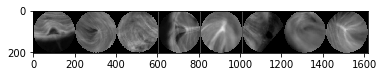

In [21]:
dataiter = iter(dataset_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
classes = ["pos","neg","pos_o","nuc","non"]
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))
print(labels)

In [60]:
data = pd.read_csv(csv_path, sep=" ")
labels = data.loc[0]
single_image_label = int(labels['class']) # float
x = labels['x']
y = 1 - labels['y'] # origin of PIL image is top-left
img_index = labels['image_index']
img = Image.open('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/000001.jpg')
img = img.convert('L')
img = torchvision.transforms.functional.resize(img, (300,300), interpolation=2)
width, height = img.size
img = ImageOps.expand(img, border=pad_size, fill=0)
xmin = width * x - window_size/2 + pad_size
ymin = height * y - window_size/2 + pad_size
xmax = width * x + window_size/2 + pad_size
ymax = height * y + window_size/2 + pad_size
img_resized = img.crop((xmin, ymin, xmax, ymax))
img_resized = torchvision.transforms.functional.resize(img_resized, (200,200), interpolation=2)
im_masked = img_resized*mask
im_masked = Image.fromarray(im_masked.astype('uint8'), 'L')

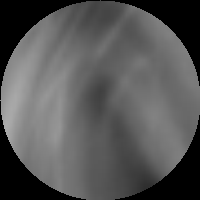

In [33]:
im_masked